# Todo:
-Prendre en compte le fait de pouvoir séparer les marchandises
-Gérer plus de 10 marchandises dans la matrice d'instance

La Classe "Env" Sert à gérer un environnement. 
Un environnement est caractérisé par un graphe, représenté par une matrice d'adjacence pondérée entre les différents sommets, et l'état des camions sur le graphe (nombre de marchandises transportées).

La génération aléatoire d'un graphe se fait sur un espace euclidien. On génère $N$ noeuds d'un graphe complet, et le poids des arrêtes corresponds à la distance euclidienne entre les points.

Pour mettre à jour l'environnement, on utilise la méthode ```Update_Env(self,origin,destination,size_Object):``` qui calcule le plus court chemin entre deux sommets pour une quantité de marchandise donnée.
Lors du calcul du plus court chemin, si une arrête du graph contient un camion qui à la place pour la marchandise, on met le poids de cette arrête à 0.
L'environnement est ensuite mis à jour avec le coût minimal (PCC)



In [43]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra, csgraph_from_masked

import networkx as nx
import matplotlib.pyplot as plt

def exists_in(l,e):
    for i in l:
        if i == e:
            return True
    return False
def random_graph(Grid,N):
    l = []
    G = np.zeros((Grid,Grid))
    for i in range(N):
        a = np.random.randint(0,Grid)
        b = np.random.randint(0,Grid)
        while(exists_in(l,[a,b])):
            a = np.random.randint(0,Grid)
            b = np.random.randint(0,Grid)
        l.append([a,b])
    l = np.array(l)
    
    G = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            G[i][j] = np.linalg.norm(l[i]-l[j])
    return G



class Env:
   
    def __init__(self, N=10,size_Trucks=10,cpy=0):
        self.N = N
        self.size_Trucks = size_Trucks
        if(cpy):
            self.matrix = None 
            self.trucks = None
        else:
            self.matrix = random_graph(N*2,N)
            self.trucks = np.zeros((N,N))
        #self.matrix = np.tril(self.matrix) + np.tril(self.matrix, -1).T
        #self.matrix = np.tril(self.matrix,-1) + np.triu(self.matrix,1)
        
        self.cost = 0

    def cpy(self):
        new = Env(self.N,self.size_Trucks,cpy=1)
        new.matrix = np.copy(self.matrix)
        new.trucks = np.copy(self.trucks)
        return new
        
    def Price(self):
        return np.sum(self.matrix * self.trucks%self.size_Trucks)
    def available(self):
        G= self.trucks%self.size_Trucks 
        return (self.size_Trucks - G) %self.size_Trucks
    
    def compute_path(self,number):
        G = self.matrix.copy()
        G_masked = np.ma.masked_values(G, 0)
        G_masked[self.available()>= number] = 0
        return G_masked
    
    def Cheapest_path(self,origin,destination,size_Object):
        G = self.compute_path(size_Object)
        graph = csgraph_from_masked(G)
        dist_matrix, predecessors = dijkstra(csgraph=graph, directed=False, indices=origin, return_predecessors=True)
        if(predecessors[destination]== origin):
            l = [origin,destination]
        else:
            l = [origin,predecessors[destination]]
            while(predecessors[l[-1]] != origin):
                l.append(predecessors[l[-1]])
            l.append(destination)
        return dist_matrix[destination],l
    
    def Update_Env(self,origin,destination,size_Object):
        new_truck = self.Cheapest_path(origin,destination,size_Object)
        predecessors = new_truck[1]
        i=0
        G_avail = self.available()
        while(predecessors[i+1]!=destination):
            if(G_avail[predecessors[i]][predecessors[i+1]] < size_Object):
                self.cost += self.matrix[predecessors[i]][predecessors[i+1]]
            self.trucks[predecessors[i]][predecessors[i+1]] += size_Object
            self.trucks[predecessors[i+1]][predecessors[i]] += size_Object
            i+=1
        if(G_avail[predecessors[i]][predecessors[i+1]] < size_Object):
            self.cost += self.matrix[predecessors[i]][predecessors[i+1]]
        self.trucks[predecessors[i]][predecessors[i+1]] += size_Object
        self.trucks[predecessors[i+1]][predecessors[i]] += size_Object
        return
    def get_cost(self):
        return self.cost
    def get_N(self):
        return self.N


La classe instance à pour but de gérer l'intégralité d'une instance, de la création à la résolution:

On génère d'abbord une matrice de taille $N\times N$ d'entiers contenant le nombre de marchandises à entreposer d'un entrepôt à un autre (c'est à dire un sommet du graphe à un autre). 
On crée ensuite un environement, et on calcul le coût nécéssaire pour gérer toutes les marchandises.
Plusieurs politiques peuvent être essayées :
-On vide d'abbord l'entrepôt le plus chargé.
-On vide d'abbord l'entrepôt le moins chargé.
-On commence par les marchandises les plus petites.
-On commence par les marchandises les plus grosses.

Plus difficile, pour aller plus loin, non géré par ce code:
-On essaye de calculer l'impact qu'aura une marchandise sur les autres, et on prends la marchandise qui minimise cette valeur.

In [44]:


class Instance:
   
    def __init__(self, env,objects):
        self.env = env.cpy()
        self.objects = objects
        np.fill_diagonal(self.objects,0)
    
    def gen_bigger_bigger(self):
        for i in range(self.env.N):
            origin = self.objects.sum(axis=1).argmax()
            sumn = self.objects[origin].sum()
            while(sumn > 0):
                destination = self.objects[origin].argmax()
                yield origin, destination
                sumn -= self.objects[origin][destination]
                self.objects[origin][destination] = 0
                
    def gen_bigger_object(self):
        sumn = self.objects.sum()
        while(sumn > 0):
            origin = self.objects.argmax()//env.get_N()
            destination = self.objects.argmax()%env.get_N()
            yield origin, destination
            sumn -= self.objects[origin][destination]
            self.objects[origin][destination] = 0
    def gen_random(self):
        T = np.nonzero(self.objects)
        X = np.arange(0,T[0].size)
        np.random.shuffle(X)
        for i in range(T[0].size):
            yield T[0][X[i]],T[1][X[i]]
        
    def solve(self,mode=0):
        if mode == 0:
            gen= self.gen_bigger_bigger()
        if mode == 1:
            gen = self.gen_bigger_object()
        if mode == 2:
            gen = self.gen_random()
        for origin, destination in gen:
            self.env.Update_Env(origin,destination,self.objects[origin][destination])

In [45]:
env = Env(4,10)
obj = np.random.randint(0,10,[env.get_N(),env.get_N()])
ins= Instance(env,obj)
print(obj)
for i ,j in ins.gen_random():
    print(i,j)

[[0 9 0 5]
 [1 0 8 0]
 [3 8 0 8]
 [1 9 5 0]]
3 2
3 1
3 0
2 1
0 3
1 2
2 0
1 0
2 3
0 1


In [60]:
for i in (10,100,1000):
    print(i)

10
100
1000


In [66]:
import statistics as st
x1 = []
x2 = []
x3 = []

for j in range(10,50):
    l = []
    l2 = []
    l3 = []
    for i in range(100):
        env = Env(j,100)
        obj = np.random.randint(0,100,[env.get_N(),env.get_N()])
        inst = Instance(env,obj.copy())
        inst2 = Instance(env,obj.copy())
        inst3 = Instance(env,obj.copy())
        inst3.solve(2)
        inst.solve(0)
        inst2.solve(1)
        l.append(inst.env.get_cost())
        l2.append(inst2.env.get_cost())
        l3.append(inst3.env.get_cost())
        print(j,"entrepots ",i,"/100", end ="\r")
    x1.append(st.mean(l))
    x2.append(st.mean(l2))
    x3.append(st.mean(l3))

In [68]:
x1

[779.2715033134272,
 1076.9389318741778,
 1414.4694033860803,
 1846.3286488753035,
 2355.4449639532813,
 2867.246312529477,
 3457.37398723009,
 4321.178289970307,
 5369.111191627115,
 6445.808040794356,
 7603.4683889204625,
 8833.200194158764,
 10106.39965838773,
 11452.923136519008,
 13236.361244450196,
 14901.108130288996,
 16866.534931879312,
 18799.888946065556,
 21437.823429282504,
 23939.850098339975,
 26559.900215064154,
 29707.53479800864,
 32630.104990011183,
 36543.203817842485,
 42083.804178425205,
 45649.6054863289,
 49021.649926012906,
 53301.13351743814,
 57613.850425481316,
 61831.02948982832,
 67773.47431605107,
 73152.20912771681,
 77780.08142902359,
 82382.31389718794,
 90526.03213385715,
 96327.23220156011,
 102924.11547738008,
 110493.46269959667,
 117477.51550834907,
 124458.90700543138]

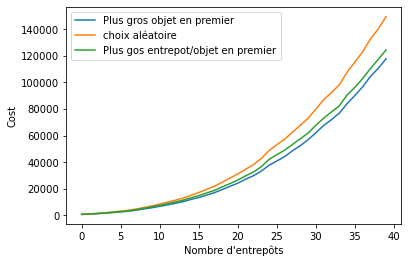

In [69]:

plt.plot(x2,label="Plus gros objet en premier")

plt.plot(x3,label="choix aléatoire")

plt.plot(x1,label="Plus gos entrepot/objet en premier")
plt.xlabel("Nombre d'entrepôts")
plt.ylabel("Cost")
plt.legend()

In [283]:

b=test(1,2)
a=test(cpy=0)
a.a,a.b,b.a,b.b

(0, 0, 1, 2)

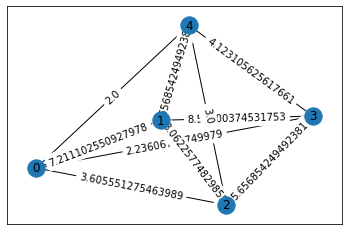

In [61]:
G = nx.from_numpy_matrix(x.matrix)
pos=nx.spring_layout(G)
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
#nx.draw(G)

plt.show()